#Figure 8 - Functional imaging

This notebook loads in the data corresponding to figure 8, both the low and high magnification data sets.

We then compute:
- The mean intenstity image of the low magnification 8A)
- The crosscorrelation image with region 1, 8B)
- The mean intenstity image of the high magnification 8C) with rois
- The example traces and roi correlation histograms

## Setup plotting

In [2]:
from showit import image
%matplotlib inline

In [3]:
from skimage.io import imsave

##Load in low magnigication data

In [4]:
from thunder.images import frombinary

path = '/tier2/freeman/Nick/2pRAM.paper/00'

data = frombinary(path + '/images', engine=sc)
data.cache()

Images
mode: spark
dtype: int16
shape: (2628, 500, 468)

## Compute and inspect the mean image

In [5]:
mean = data.mean().toarray()

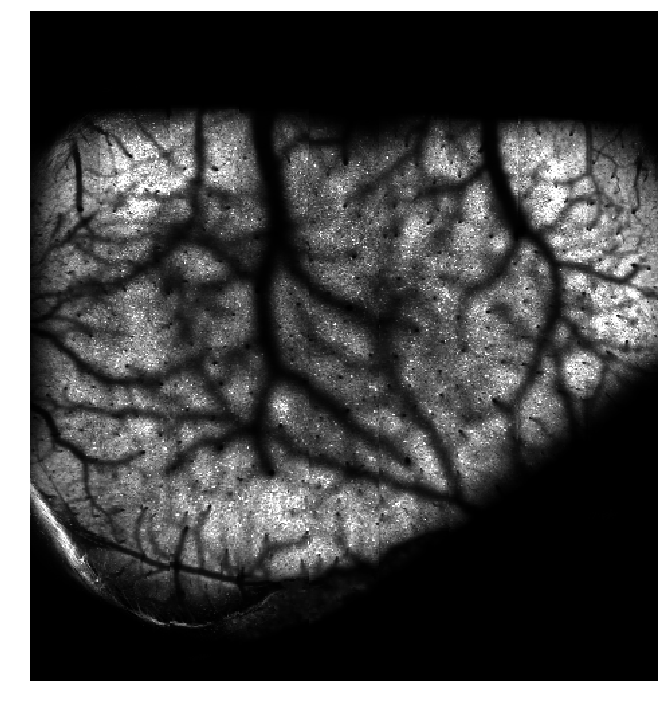

In [6]:
image(mean, clim=(0, 2500), size = 12);

In [19]:
imsave(path + '/summary/mean.tif', mean.astype('float32'), plugin='tifffile', photometric='minisblack')

##Average activity in subregions

In [8]:
from json import load
from regional import many

with open(path + '/sources/sources.json') as dataFile:
    sources = load(dataFile)
regions = many([x['coordinates'] for x in sources])

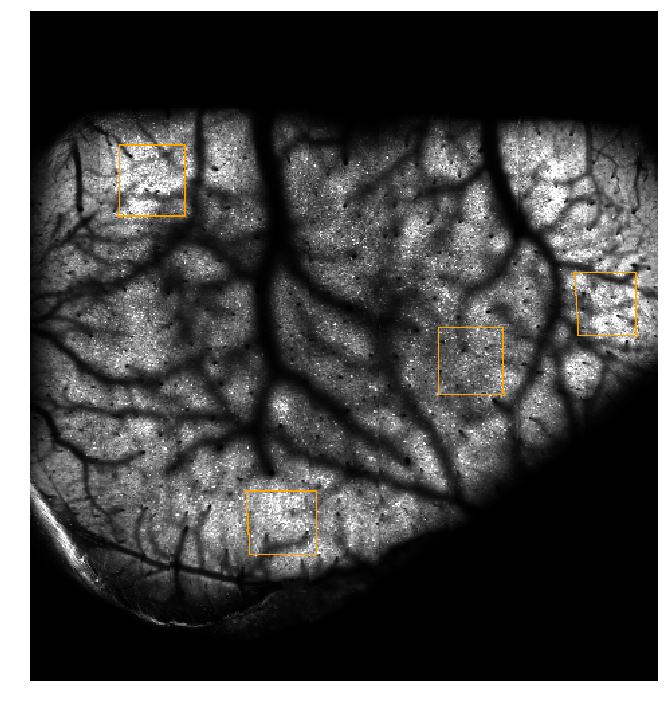

In [13]:
img = regions.mask(base=(mean/2500).clip(0,1), stroke='orange', fill = None)
image(img, size = 12);

In [15]:
from extraction.model import ExtractionModel

em = ExtractionModel(regions)
traces = em.transform(data).tolocal()
traces.tobinary(path + '/traces', overwrite = True)

In [16]:
from numpy import array
time = array([float(x)/4.38 for x in range(traces.shape[1])])

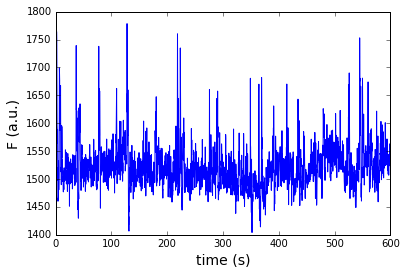

In [21]:
from matplotlib.pyplot import plot, xlim, xlabel, ylabel 

plot(time, traces[0].values.T);
xlabel('time (s)', fontsize=14);
xlim([0, 600])
ylabel('F (a.u.)', fontsize=14);

##Make correlation map

In [35]:
records = data.uniform_filter(5).toseries(size = 10)
records.cache()

Series
mode: spark
dtype: int16
shape: (500, 468, 2628)

In [36]:
corr = records.correlate(traces[0].values).toarray()

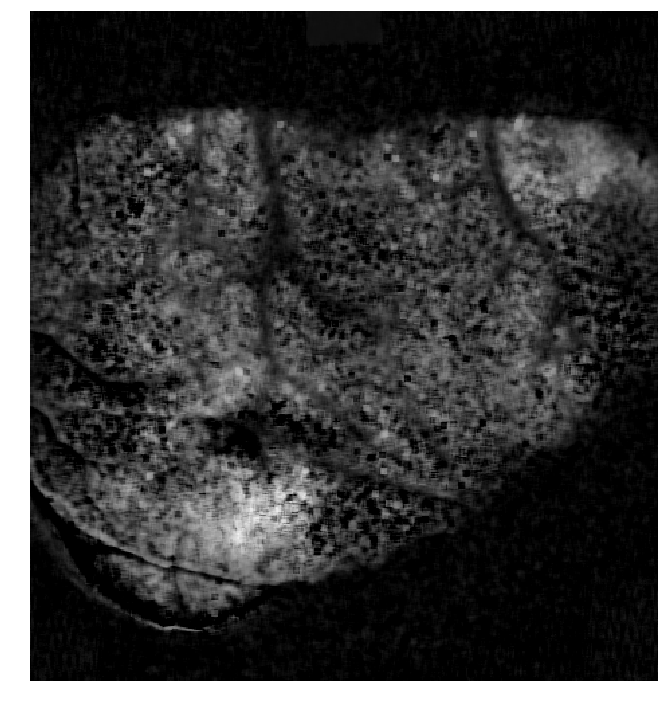

In [39]:
image(corr, clim = (0, 0.7), size = 12);

In [40]:
imsave(path + '/summary/corr.tif', mean.astype('float32'), plugin='tifffile', photometric='minisblack')

#Load in high magnigication data

In [32]:
from thunder.images import frombinary

path = '/tier2/freeman/Nick/2pRAM.paper/01'

data = frombinary(path + '/images', engine=sc)
data.cache()

Images
mode: spark
dtype: int16
shape: (6000, 4, 512, 512)

##Perform motion correction

In [38]:
from registration import CrossCorr

# use first 60 frames as a reference
reference = data[:60].mean().toarray()

# perform registration on each plane independently
algorithm = CrossCorr(axis=0)
model = algorithm.fit(data, reference)
registered = model.transform(data)

In [40]:
mean = registered.mean().toarray()

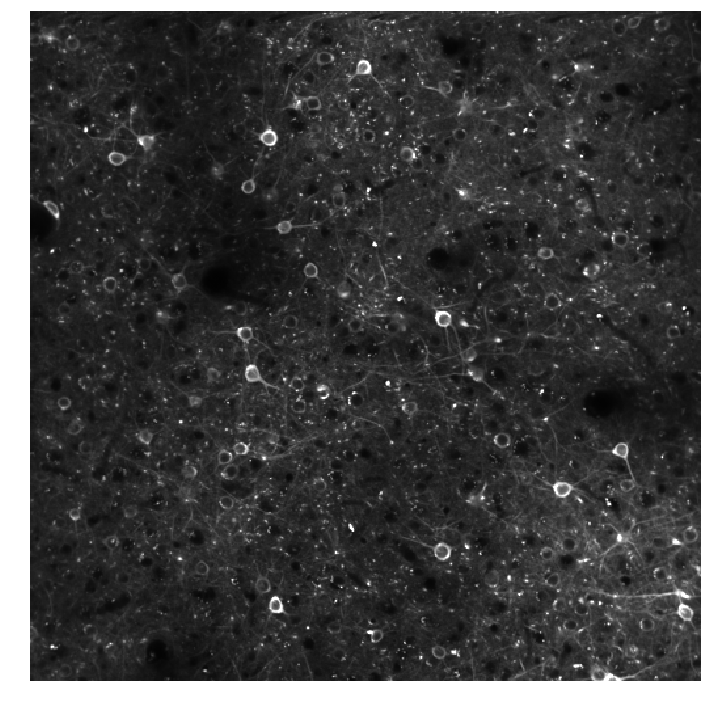

In [41]:
image(mean[3], clim=(0, 2500), size = 12);

In [42]:
imsave(path + '/summary/mean.tif', mean.astype('float32'), plugin='tifffile', photometric='minisblack')

##Display sources

In [61]:
from json import load
from regional import many

regions = []
for i in range(4):
    name = '/sources-%d.json' % i
    with open(path + '/sources' + name) as dataFile:
        sources = load(dataFile)
    regions.append(many([x['coordinates'] for x in sources]))

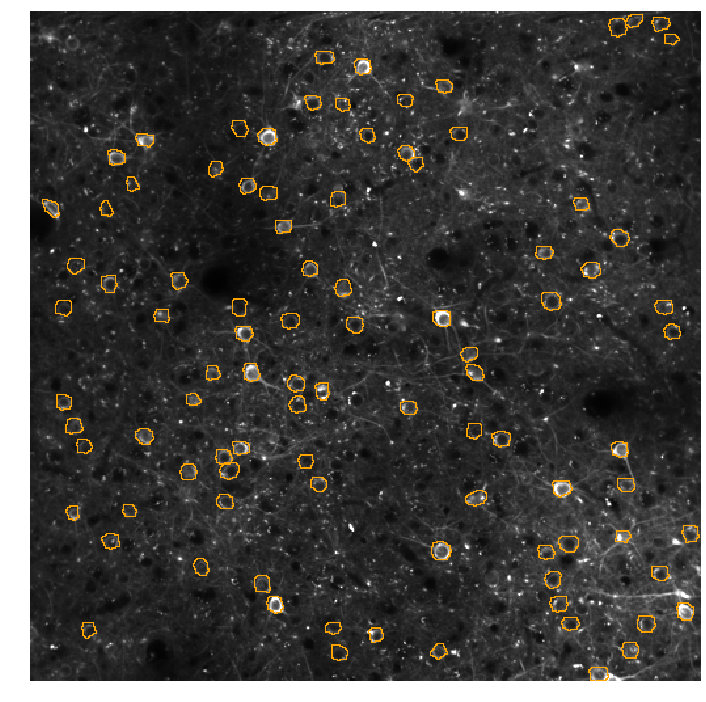

In [76]:
plane = 3
img = regions[plane].mask(base=(mean[plane]/2500).clip(0,1), stroke='orange', fill = None)
image(img, size = 12);

##Compute and inspect neuron activity traces

In [90]:
from extraction.model import ExtractionModel

traces = []
for plane in range(4):
    em = ExtractionModel(regions[plane])
    trace = em.transform(registered[:,plane,:,:].squeeze()).normalize('window', window=500)
    trace.tobinary(path + '/traces/%d' % plane, overwrite = True)
    traces.append(trace.tolocal())

In [113]:
from numpy import array
time = array([float(x)/9.66 for x in range(traces[0].shape[1])])

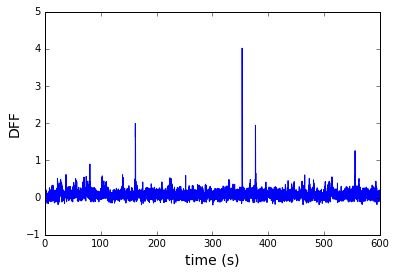

In [153]:
from matplotlib.pyplot import plot, xlim, xlabel, ylabel 

plane = 0
neuron = 20

plot(time, traces[plane][neuron].values.T);
xlabel('time (s)', fontsize=14);
xlim([0, 600])
ylabel('DFF', fontsize=14);

##Extract temporal correlations

In [130]:
# compute maximum activity in region 1
avg = traces[0].max()

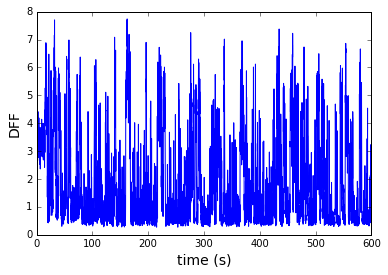

In [152]:
from matplotlib.pyplot import plot, xlim, xlabel, ylabel 

plt.plot(time, avg.values.T);
plt.xlabel('time (s)', fontsize = 14);
plt.xlim([0, 600])
plt.ylabel('DFF', fontsize = 14);

In [136]:
# compute correlation with timeseries of each individual neuron
corr = [t.correlate(avg).values for t in traces]

##Create histograms of correlation coefficients

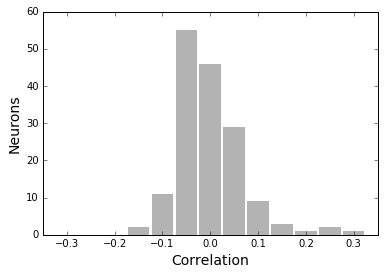

In [154]:
from numpy import linspace
from matplotlib.pyplot import hist, xlim, xlabel, ylabel 

plane = 2
hist(corr[plane],bins=linspace(-.525,.525,22), rwidth=0.9, edgecolor='none', color = [0.7,0.7,0.7]);
xlim([-.35, .35])
xlabel('Correlation', fontsize = 14);
ylabel('Neurons', fontsize = 14);